# Dev
Data: 
- [PaJama Jazz Github and Docs](https://almostimplemented.github.io/PiJAMA/)
- [PaJama Dataset Downloadh](https://zenodo.org/records/8354955)
- [PaJama Paper](https://transactions.ismir.net/articles/10.5334/tismir.162#B15)
---- 
MidiTok
- [Data Loading](https://miditok.readthedocs.io/en/latest/pytorch_data.html)


- today: proof of concept
- tmrw: scale up sizes, hyper param search, upload to google drive for training, get validation set up
- 

## Imports and Loads

In [1]:
from datasets import load_dataset;
import librosa;
import scipy.io.wavfile as wav
import os
import sys
import sys
sys.path.append("../")
sys.path.append("./")
import numpy as np
import matplotlib.pyplot as plt;
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi
from pathlib import Path
from collections import Counter
from tqdm import tqdm
from symusic import Score
from torch.utils.data import DataLoader

%matplotlib inline


tokenize_dataset= False
chunk_dataset = False

/Users/ryanrodriguez/PycharmProjects/personal/ood_music/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from miditok import REMI, TokenizerConfig
import miditok

In [3]:
file_paths_relative = list(Path("..", "data", "midi").glob("**/*.midi"))
file_paths_abs = [file.resolve() for file in file_paths_relative]

n_files = len(file_paths_abs)

rng_idxs = np.random.default_rng().choice(a=n_files, size=n_files, replace=False)

In [4]:
tr_amt = int(n_files * .75)
val_amt = int(n_files * .125)
te_amt = n_files - (tr_amt + val_amt)
print(f"Total Train Files: {tr_amt}")
print(f"Total Val Files: {val_amt}")
print(f"Total Test Files: {te_amt}")

tr_idxs = rng_idxs[:tr_amt]
val_idxs = rng_idxs[tr_amt:tr_amt+val_amt]
te_idxs = rng_idxs[tr_amt+val_amt:]


Total Train Files: 2082
Total Val Files: 347
Total Test Files: 348


In [5]:
tr_file_paths = [file_paths_abs[i] for i in tr_idxs]
val_file_paths = [file_paths_abs[i] for i in val_idxs]
val_file_paths = [file_paths_abs[i] for i in te_idxs]

In [7]:
def load_midi_to_pm(path):
    with open(path, 'rb') as m:
            return pretty_midi.PrettyMIDI(m)

def note_events(pmidi, start=0, end=0):
    notes = [note for instrument in pmidi.instruments for note in instrument.notes if note.start > start and note.end < end]
    return notes


def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))


## Data Viz

In [6]:
config = TokenizerConfig(num_velocities=16, use_chords=True, use_programs=True)
tokenizer = REMI(config)

/var/folders/3_/f8wt55b12b5683gxyp7dcqyc0000gn/T/ipykernel_6745/3694888452.py:1: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  config = TokenizerConfig(num_velocities=16, use_chords=True, use_programs=True)


In [7]:
midi_note_dist = []

for file in tr_files:
    midi = Score(file)
    tok = tokenizer(midi)
    midi_note_dist.append(len(tok.ids))

NameError: name 'tr_files' is not defined

Avg Tokens Per File: 5092.7982799061765
Max Tokens Per File: 65506
Min Tokens Per File: 94


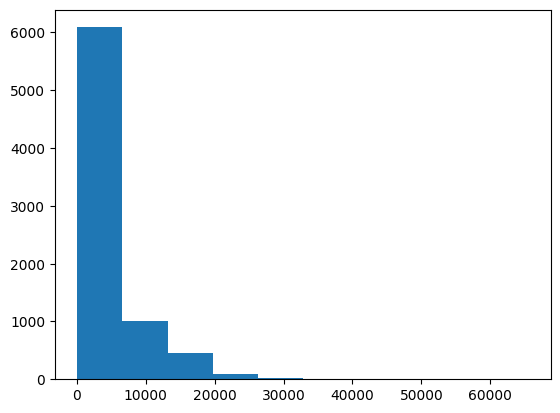

In [34]:
print(f"Avg Tokens Per File: {np.mean(midi_note_dist)}")
print(f"Max Tokens Per File: {np.max(midi_note_dist)}")
print(f"Min Tokens Per File: {np.min(midi_note_dist)}")

plt.hist(midi_note_dist);

## MidiTok Tokenization

### 1. Train Tokenizer

In [8]:
config = TokenizerConfig(num_velocities=16, use_chords=True, use_programs=True)
tokenizer = REMI(config, params="../data/tokenizer/tokenizer.json")

# tokenizer.train(vocab_size=30000, model="BPE", files_paths=tr_file_paths)

/var/folders/3_/f8wt55b12b5683gxyp7dcqyc0000gn/T/ipykernel_6745/2779315171.py:1: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  config = TokenizerConfig(num_velocities=16, use_chords=True, use_programs=True)
/Users/ryanrodriguez/PycharmProjects/personal/ood_music/lib/python3.9/site-packages/miditok/midi_tokenizer.py:3252: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  self.config = TokenizerConfig()
/Users/ryanrodriguez/PycharmProjects/personal/ood_music/lib/python3.9/site-packages/miditok/classes.py:702: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  return cls(**input_dict, **kwargs)


### 2. Tokenize Dataset

In [9]:
if tokenize_dataset:
    tokenizer.tokenize_dataset(files_paths=tr_file_paths, out_dir='../data/midi_tokenized/bpe_30k')

### 3. Chunk Tokenized Data

In [10]:
seq_len = 1000
dataset_chunks_dir = Path("../data/midi_tokenized/bpe_30k/chunks/", str(seq_len))

if chunk_dataset:
    miditok.pytorch_data.split_files_for_training(
        files_paths=tr_file_paths,
        tokenizer=tokenizer,
        save_dir = dataset_chunks_dir,
        max_seq_len = seq_len
    )

### 4. Create Dataset / Dataloader / Collater

In [11]:
dataset = miditok.pytorch_data.DatasetMIDI(
    files_paths = dataset_chunks_dir.glob("**/*.midi"),
    tokenizer=tokenizer,
    max_seq_len=seq_len,
    bos_token_id = tokenizer["BOS_None"],
    eos_token_id = tokenizer["EOS_None"],
)

collator = miditok.pytorch_data.DataCollator(tokenizer.pad_token_id, copy_inputs_as_labels=True, shift_labels=True)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=collator)


## Model 

In [12]:
class AttnHead(nn.Module):
    def __init__(self, head_size, n_embed, block_size, dropout=0.5):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.ones(block_size, block_size))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape  
        k = self.key(x)  # (B, T, C) # important, k & q are generated independent of eachother
        q = self.query(x) # (B, T, C)
        v = self.value(x)
        
        wei = q @ k.transpose(-2, -1) * (C**-0.5)  # (B, T, 16) @ (B, 16, T) ---> (B, T, T) [resulting matrix contains kq dot product from pairs of tokens]
        wei = wei.masked_fill(self.tril[:T, :T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
         
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttn(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout=0.5):
        super().__init__()
        self.heads = nn.ModuleList([AttnHead(head_size, n_embd, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x): 
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embed, 4 * n_embed), 
                                 nn.ReLU(), 
                                  nn.Linear(4 * n_embed, n_embed),
                                  nn.Dropout(dropout)
                                )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, num_heads, block_size):
        super().__init__()
        head_size = n_embed // num_heads # size of concatenated attn vectors is same size as embedding size
        self.sa = MultiHeadAttn(num_heads, head_size, n_embed, block_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)


    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class DecoderTransformer(nn.Module):
    def __init__(self, n_embd, n_head, n_blocks, block_size, dropout=0.5):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size) for _ in range(n_blocks)])  # the * unpacks the contents of the list, as seqential cannot take a list
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, x, targets=None):
        B, T = x.shape
        tok_emb = self.token_embedding_table(x)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x) # B, T, vocab_size

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.reshape(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

class LayerNorm: # coded for instruction but used pytorch implentaiton in code
    def __init__(self, dim, eps=1e-5):
        self.gamma = torch.ones(dim) # sd param
        self.beta = torch.zeros(mu) # mean param
        self.eps = eps
    
    def __call__(self, x):
        xmean = x.mean(1, keepdim=True)
        xvar = x.var(1, keepdim=True)
        xhat = (x - xmean) / (torch.sqrt(xvar) + x)  # normalize rows to unit var
        self.out = (self.gamma * xhat) + self.beta
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]

In [24]:
batch_size = 32
block_size = 1000
max_steps = 10_000 
learning_rate = 0.003
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10 
n_embd = 20
n_blocks = 3
n_head = 4
n_layer = 3 
dropout = 0.2
vocab_size = 30_000

In [25]:
model = DecoderTransformer(n_embd, n_head, n_blocks, block_size, dropout)

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(50):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for i, data in enumerate(dataloader):
        x = data['input_ids']
        y = data['labels']
        mask = data['attention_mask']
        preds, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (i+1) % 100 == 0:
            recent_losses = losses[-100:]
            print(f"Epoch {epoch}: step {i+1}: {np.mean(recent_losses):0.5}")
    learning_rate *= 0.9
    

Epoch 0: step 100: 8.1566
Epoch 0: step 200: 8.1462
Epoch 0: step 300: 7.9949
Epoch 0: step 400: 8.1005
Epoch 0: step 500: 8.0043
Epoch 0: step 600: 8.0509
Epoch 0: step 700: 7.9769
Epoch 0: step 800: 7.8276
Epoch 0: step 900: 7.9104
Epoch 1: step 100: 7.8554
Epoch 1: step 200: 7.8228
Epoch 1: step 300: 7.7014
Epoch 1: step 400: 7.8245
Epoch 1: step 500: 7.7396
Epoch 1: step 600: 7.7984
Epoch 1: step 700: 7.7503
Epoch 1: step 800: 7.6116
Epoch 1: step 900: 7.7073
Epoch 2: step 100: 7.6822
Epoch 2: step 200: 7.6547
Epoch 2: step 300: 7.5526


KeyboardInterrupt: 

In [27]:
losses = torch.tensor([losses]).view(6, -1)

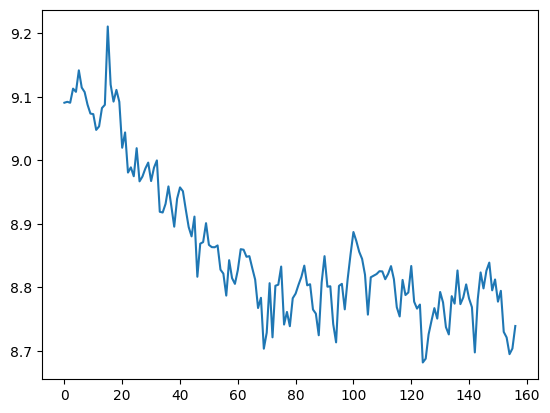

In [28]:
plt.plot(losses.mean(dim=0))

In [21]:
losses

[9.296821594238281,
 9.284692764282227,
 9.2449951171875,
 9.168244361877441,
 9.123856544494629,
 9.235989570617676,
 9.214149475097656,
 9.124139785766602,
 9.18854808807373,
 9.221329689025879,
 9.04165267944336,
 8.989245414733887,
 9.02587890625,
 9.043289184570312,
 9.018869400024414,
 9.095885276794434,
 9.207191467285156,
 9.04786491394043,
 9.211526870727539,
 9.137948036193848,
 8.984140396118164,
 9.157294273376465,
 9.043255805969238,
 8.952750205993652,
 9.07327651977539,
 9.022217750549316,
 9.127347946166992,
 9.009716033935547,
 9.132254600524902,
 9.18262767791748,
 9.108016014099121,
 9.238733291625977,
 9.12653636932373,
 9.133955001831055,
 9.158370018005371,
 9.098199844360352,
 9.147333145141602,
 9.072145462036133,
 9.130309104919434,
 9.211050987243652,
 9.232894897460938,
 9.209750175476074,
 9.131736755371094,
 9.070906639099121,
 9.362525939941406,
 9.30909538269043,
 9.004761695861816,
 8.993142127990723,
 9.109169006347656,
 9.226678848266602,
 9.2726621627